<a href="https://colab.research.google.com/github/smirnovaanastasia1234/MOMO_III/blob/main/%D0%90%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7_%D0%B2%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%BD%D1%8B%D1%85_%D1%80%D1%8F%D0%B4%D0%BE%D0%B2_II_%D1%87%D0%B0%D1%81%D1%82%D1%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Итоговый проект «Анализ временных рядов_II_часть»**

# **Import библиотек**

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [77]:
!pip install sktime[all_extras]

In [ ]:
import sktime

In [78]:
from sktime.utils.plotting import plot_series
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


In [79]:
from sktime.forecasting.tbats import TBATS

In [ ]:
!pip install numba

# **Классификация временных рядов**

In [80]:
data = pd.read_csv('https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv')
data['timestamp'] = pd.to_datetime(data['timestamp'])
#data = data.set_index(['timestamp']).asfreq('h')
data.head(2)

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127


Посмотрим на часы в которые совершались поездки

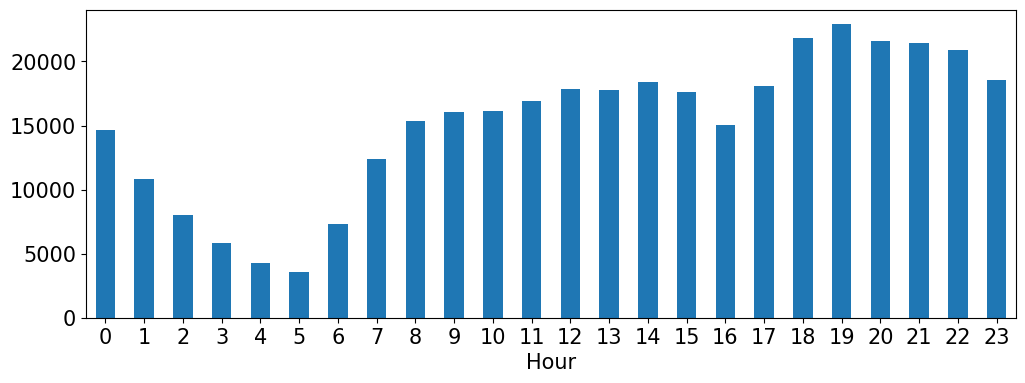

In [85]:
fig, axs = plt.subplots(figsize=(12, 4))
data.groupby(
                    data["timestamp"].dt.hour)["value"].mean().plot(kind='bar',
                    rot=0,
                    ax=axs)
plt.xlabel("Hour");

In [84]:
data['hours'] = data['timestamp'].dt.hour

In [86]:
time = {
    'night': (0, 5),
    'morning': (6, 11),
    'afternoon': (12, 17),
    'evening': (18, 24),
}

In [87]:
def to_segments(hour):
    for segment, (st, end) in time.items():
        if st <= hour <= end:
            return segment
data['time'] = data['hours'].apply(to_segments)
data.fillna('night', inplace=True)

In [88]:
data.head()

,timestamp,value,hours,time
0,2014-07-01 00:00:00,10844,0,night
1,2014-07-01 00:30:00,8127,0,night
2,2014-07-01 01:00:00,6210,1,night
3,2014-07-01 01:30:00,4656,1,night
4,2014-07-01 02:00:00,3820,2,night


In [89]:
data = data.set_index(['timestamp']).asfreq('h')

In [90]:
morning = data[data['time'] == "morning"]['value']
afternoon = data[data['time'] == "afternoon"]['value']
evening = data[data['time'] == "evening"]['value']
night = data[data['time'] == "night"]['value']

In [91]:
morning

timestamp
2014-07-01 06:00:00     6526
2014-07-01 07:00:00    13857
2014-07-01 08:00:00    17920
2014-07-01 09:00:00    19539
2014-07-01 10:00:00    18984
                       ...  
2015-01-31 07:00:00     4803
2015-01-31 08:00:00     8363
2015-01-31 09:00:00    13522
2015-01-31 10:00:00    17645
2015-01-31 11:00:00    20270
Name: value, Length: 1290, dtype: int64

In [92]:
morning = morning.values.reshape(-1, morning.resample('D').count().value_counts().index[0])
afternoon = afternoon.values.reshape(-1, afternoon.resample('D').count().value_counts().index[0])
evening = evening.values.reshape( -1, evening.resample('D').count().value_counts().index[0])
night = night.values.reshape(-1, night.resample('D').count().value_counts().index[0])

In [93]:
X = np.concatenate((
    morning,
    afternoon,
    evening,
    night,
    ))
y = np.concatenate((
                    np.ones(night.shape[0]) - 1,
                    np.ones(night.shape[0]) + 0,
                    np.ones(night.shape[0]) + 1,
                    np.ones(night.shape[0]) + 2,
                   ))
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(602, 6) (602,) (258, 6) (258,)


## **RandomForestClassifier**

In [94]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [95]:
def model (y_test, y_pred):
    sns.set_context(context='paper', font_scale=2, rc=None)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in confusion_matrix(y_test, y_pred).flatten()]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names, group_counts)]
    labels = np.asarray(labels).reshape(2, 2)
    ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='', cmap='Blues',xticklabels=list(time.keys()), yticklabels=list(time.keys()))
    ax.set(title = 'Confusion matrix')
    plt.show()

In [96]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
print(f' test score {clf.score(x_test, y_test):.3f}')

 test score 0.953


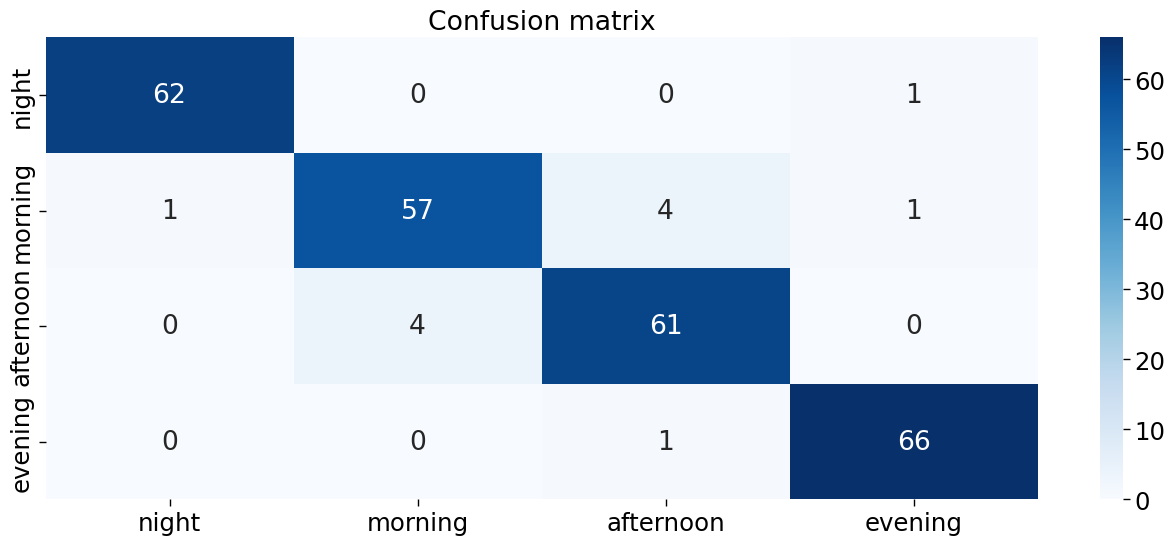

In [97]:
model(y_test, y_pred)

## **STSF**

In [98]:
from sktime.classification.interval_based import SupervisedTimeSeriesForest
from sktime.datasets import load_unit_test

In [100]:
x_train, y_train = load_unit_test(split="train", return_X_y=True)
x_test, y_test = load_unit_test(split="test", return_X_y=True)
clf = SupervisedTimeSeriesForest(n_estimators=5)
clf.fit(x_train, y_train)
SupervisedTimeSeriesForest(n_estimators=5)
y_pred = clf.predict(x_test)
print(f' test score {clf.score(x_test, y_test):.3f}')

 test score 0.955


## **KNeighborsTimeSeriesClassifier**

In [101]:
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
clf = KNeighborsTimeSeriesClassifier(n_neighbors=1, distance="dtw")
clf.fit(x_train, y_train)
print(f' test score {clf.score(x_test, y_test):.3f}')

 test score 0.955


Получены высокие результаты свыше 0,955

## **TSAI**

In [102]:
!pip install tsai --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.2/324.2 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 13.8 MB/s eta 0:00:00


In [103]:
from tsai.all import *
import warnings

computer_setup()

os              : Linux-6.1.58+-x86_64-with-glibc2.35
python          : 3.10.12
tsai            : 0.3.8
fastai          : 2.7.13
fastcore        : 1.5.29
torch           : 2.1.0+cu121
device          : cpu
cpu cores       : 1
threads per cpu : 2
RAM             : 12.67 GB
GPU memory      : N/A


In [104]:
import torch
from torch import nn

In [105]:
X_ = np.atleast_3d(X).transpose(0, 2, 1)
X_ = X_.astype('float32')

In [106]:
class_map = {
    0:'morning',
    1:'afternoon',
    2:'evening',
    3:'night',
    }
class_map

labeler = ReLabeler(class_map)
y_ = labeler(y)

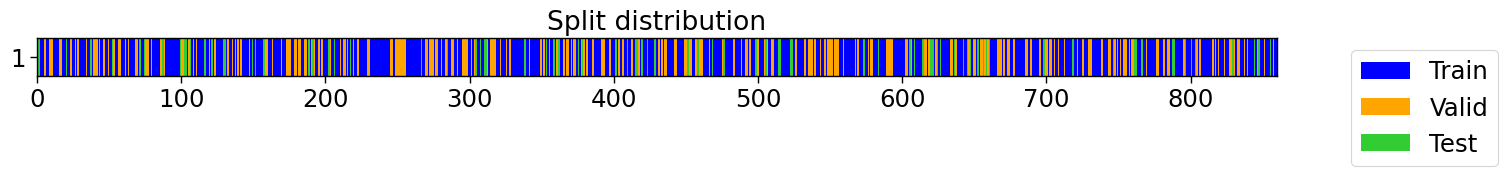

((#516) [687,640,89,118,561,4,572,208,681,775...],
 (#258) [795,452,385,276,833,381,269,229,349,725...],
 (#86) [847,468,103,608,361,116,375,514,656,423...])

In [107]:
splits = get_splits(y,
                    n_splits=1,
                    valid_size=0.3,
                    test_size=0.1,
                    shuffle=True,
                    balance=False,
                    stratify=True,
                    random_state=42,
                    show_plot=True,
                    verbose=True)
splits

In [108]:
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X_, y_, tfms=tfms, splits=splits)

bs = 128
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[bs, bs*2])

In [109]:
archs = [
    (ResNet, {}),
    (InceptionTime, {}),
    (XceptionTime,  {}),
    (TCN, {}),
    (RNNPlus, {'n_layers':3, 'bidirectional': True} ),
    (RNNPlus, {'n_layers':3, 'bidirectional': False} ),
    (LSTM,    {'n_layers':3, 'bidirectional': False}),
    (LSTM,    {'n_layers':3, 'bidirectional': True}),
        ]

In [110]:
results = pd.DataFrame(columns=['arch', 'hyperparams', 'total params', 'train loss', 'valid loss', 'accuracy', 'time'])

for i, (arch, k) in enumerate(archs):

    model = create_model(arch, dls=dls, **k)

    print(model.__class__.__name__)

    learn = Learner(dls, model,  metrics=accuracy)
    start = time.time()
    learn.fit_one_cycle(20, 1e-3)
    elapsed = time.time() - start
    vals = learn.recorder.values[-1]
    results.loc[i] = [arch.__name__, k, count_parameters(model), vals[0], vals[1], vals[2], int(elapsed)]
    results.sort_values(by='accuracy', ascending=False, ignore_index=True, inplace=True)
    clear_output()
    display(results)

,arch,hyperparams,total params,train loss,valid loss,accuracy,time
0,ResNet,{},478724,0.104092,0.077464,0.976744,19
1,InceptionTime,{},388868,0.107194,0.083035,0.976744,20
2,XceptionTime,{},399480,0.514790,0.456112,0.972868,104
3,TCN,{},66754,1.860656,0.238598,0.930233,39
4,RNNPlus,"{'n_layers': 3, 'bidirectional': False}",51104,1.387180,1.378340,0.248062,2
5,LSTM,"{'n_layers': 3, 'bidirectional': True}",566404,1.386436,1.385286,0.248062,12
6,LSTM,"{'n_layers': 3, 'bidirectional': False}",203204,1.386610,1.386193,0.244186,6
7,RNNPlus,"{'n_layers': 3, 'bidirectional': True}",142204,1.391526,1.386402,0.232558,3


## **Аномалии во временном ряду**

In [112]:
df.head()

,Consumption,Wind
Date,,
2015-01-01,246.812,45.62
2015-01-02,286.350,55.46
2015-01-03,310.086,0.00
2015-01-04,300.702,0.00
2015-01-05,377.177,0.00


In [113]:
!pip install adtk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.6 MB/s eta 0:00:00


In [114]:
from adtk.detector import SeasonalAD
from adtk.visualization import plot

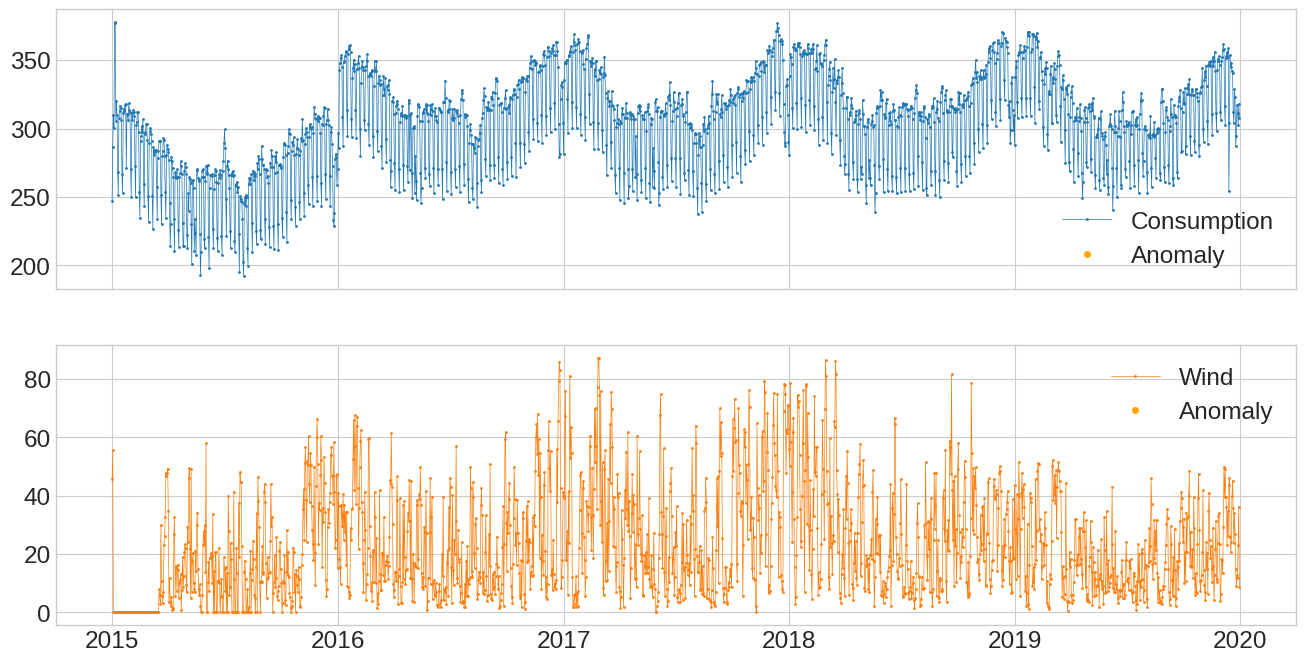

In [115]:
seasonal_vol = SeasonalAD()
anomalies = seasonal_vol.fit_detect(df.Consumption)
anomalies.value_counts()

plot(df, anomaly=anomalies, anomaly_color="orange", anomaly_tag="marker");

<Axes: >

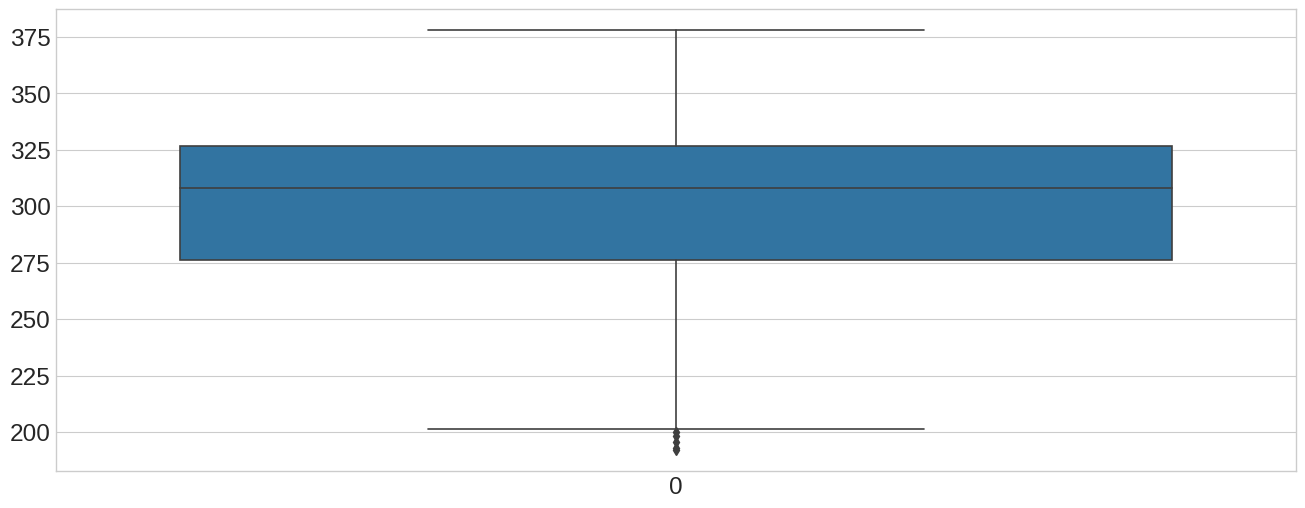

In [116]:
sns.boxplot(df['Consumption'])